# Forecasting with a Monte Carlo Simulation

This example tries to use a Monte Carlo simulation with cycle times from previous work items to simulate how long the rest of the work items could take. 

This article is inspired from previous publication from the agile / lean comunity where some ALM / issue trackers tools allow you to do some forecats based on a Monte Carlo simulation. For more details have look at the __reference section__ in the [README](https://github.com/rueedlinger/monte-carlo-simulation) of this GitHub project.

So my goal was to build a Monte Carlo simulation by my own.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import random
import numpy as np
import pandas as pd

import scipy.stats as stats


## Let's first look at previous data (cycle times)

First let's load some pervious cycle times from the CSV file [data.csv](data.csv).

In [2]:
df = pd.read_csv('data.csv', parse_dates=['created_date'])

Teh data conatins the following attributes:
- __grp__ - the project to which the work item belongs 
- __cycle_time_days__ - the cylce time in days from _todo_ stage to the _done_ stage. A cycle time -1 means the ticket was closed (rejected, won't fix, as design, etc.)
- __created_date__ - the date when the work item was created

In [3]:
df.head()

,id,grp,cycle_time_days,created_date
0,5052,0,-1,2015-02-05
1,326,0,-1,2013-12-25
2,5056,0,-1,2015-10-16
3,324,0,18,2013-08-13
4,325,0,-1,2013-12-25


Let's clean the data,

- remove cycle times < 0
- remove cycle times befor 1. Jan 2018
- group cycle times by project

In [4]:
cleaned = df[df['created_date'] > '2017-12-31']
cleaned = cleaned[cleaned['cycle_time_days'] > -1]


project_0_cycle_times = cleaned[cleaned['grp'] == 0].cycle_time_days
project_1_cycle_times = cleaned[cleaned['grp'] == 1].cycle_time_days

project_0_cycle_times = project_0_cycle_times.values
project_1_cycle_times = project_1_cycle_times.values

Next we have a look at our cycle time for our different projects.

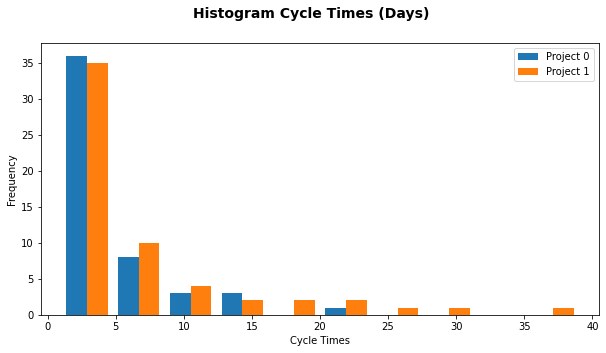

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Histogram Cycle Times (Days)', fontsize=14, fontweight='bold')
plt.hist([project_0_cycle_times, project_1_cycle_times], label=['Project 0', 'Project 1'])
ax.set_xlabel('Cycle Times')
ax.set_ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

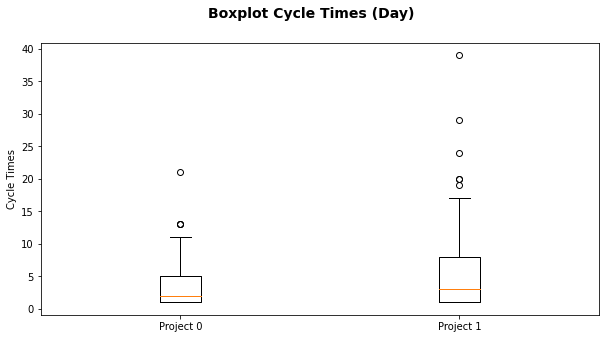

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Boxplot Cycle Times (Day)', fontsize=14, fontweight='bold')

plt.boxplot([project_0_cycle_times, project_1_cycle_times])

ax.set_xticklabels(['Project 0', 'Project 1'])
ax.set_ylabel('Cycle Times')


plt.show()

Some descriptive statistics for our cycle times

In [7]:
print(stats.describe(project_0_cycle_times))
print(stats.describe(project_1_cycle_times))

DescribeResult(nobs=51, minmax=(1, 21), mean=3.7058823529411766, variance=17.93176470588235, skewness=2.0789642149745884, kurtosis=4.474217402617895)
DescribeResult(nobs=58, minmax=(1, 39), mean=6.327586206896552, variance=61.2416817906836, skewness=2.146885333051502, kurtosis=4.8044881900831315)


An the coefficient of variation (CV).

In [8]:
print(stats.variation(project_0_cycle_times))
print(stats.variation(project_1_cycle_times))

1.131409450013304
1.2260520692931383


## Monte Carlo Simulation


### Utility Functions

In [9]:

def cumulative_sum(total_work_items, cycle_times, selector):
    total = [0]
    for i, e in enumerate(range(total_work_items)):
            total.append(selector(cycle_times) + total[i])
    return total    


def simulate_cycle_times(num_of_iterations, total_work_items, cycle_times):
    list_random_walks = []
    totals = []
    
    for i in range(num_of_iterations):
        list_random_walks.append(
            cumulative_sum(total_work_items, cycle_times, random.choice))
    
    for i in list_random_walks:
        totals.append(i[-1])
    
    return totals, list_random_walks



### When are the next 30 work items finished?
Let's simulate for 'project 0' how many days it might take to finish the next 30 work items.

First just simulate one run. 

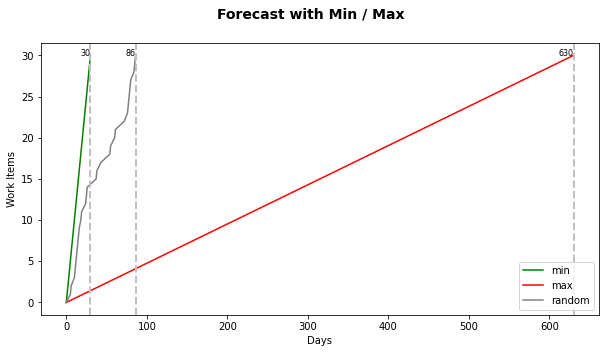

In [10]:
total_work_items = 30

cumulative_sum_min = cumulative_sum(total_work_items, project_0_cycle_times, min)
cumulative_sum_max = cumulative_sum(total_work_items, project_0_cycle_times, max)
cumulative_random = cumulative_sum(total_work_items, project_0_cycle_times, random.choice)

range_work_items = [x for x in range(total_work_items + 1)]

fig, ax = plt.subplots(figsize=(10, 5))


fig.suptitle('Forecast with Min / Max', fontsize=14, fontweight='bold')

plt.plot(cumulative_sum_min, range_work_items, label='min',  color='green')
plt.plot(cumulative_sum_max, range_work_items, label='max', color='red')
plt.plot(cumulative_random, range_work_items, label='random', color='gray')

value_max = cumulative_sum_max[-1]
value_min = cumulative_sum_min[-1]
value_random =  cumulative_random[-1]

plt.axvline(value_max, color='silver', linestyle='dashed', linewidth=2)
plt.axvline(value_min, color='silver', linestyle='dashed', linewidth=2)
plt.axvline(value_random, color='silver', linestyle='dashed', linewidth=2)

t = ax.text(value_max, total_work_items, value_max, ha="right", size=8)
t = ax.text(value_min, total_work_items, value_min, ha="right", size=8)
t = ax.text(value_random, total_work_items, value_random, ha="right", size=8)

ax.set_xlabel("Days")
ax.set_ylabel("Work Items")

plt.legend(loc='lower right')


plt.show()


Now let's run the same simulation 5000 times.

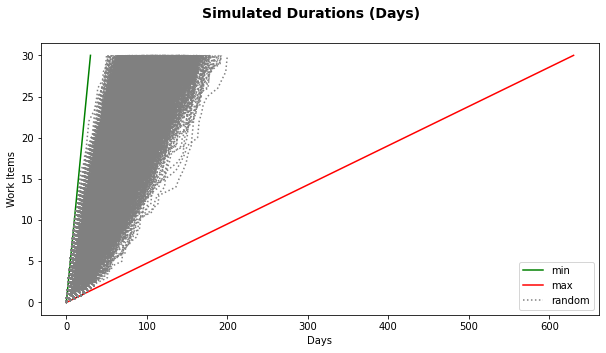

In [12]:
num_of_iterations = 5000
total_work_items = 30



simulated_total, simulated_work_done = simulate_cycle_times(num_of_iterations, total_work_items, project_0_cycle_times)

fig, ax = plt.subplots(figsize=(10, 5))

fig.suptitle('Simulated Durations (Days)', fontsize=14, fontweight='bold')

plt.plot(cumulative_sum_min, range_work_items, label='min',  color='green')
plt.plot(cumulative_sum_max, range_work_items, label='max', color='red')
plt.plot(0, 0, linestyle='dotted', color='gray', label='random')


for r in simulated_work_done:
    plt.plot(r, range_work_items, linestyle='dotted', color='gray')

ax.set_xlabel("Days")
ax.set_ylabel("Work Items")

plt.legend(loc='lower right')
plt.show()

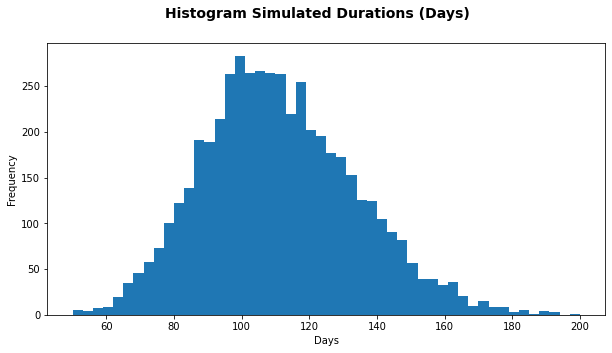

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Histogram Simulated Durations (Days)', fontsize=14, fontweight='bold')
ax.set_xlabel('Days')
ax.set_ylabel('Frequency')
plt.hist(simulated_total, bins=50);

We might end up with the 30 work items in 142 days with a probability of 90%.

In [14]:
np.quantile(simulated_total, q=[0.90,0.95,0.99])

array([141.  , 150.  , 168.01])

### How many work items might be finished in 300 days?

No we want to answer the question how many work items we can finish in the next 300 days with a probability of 85%